<a href="https://colab.research.google.com/github/samyarsworld/Human-segmentation-deep-learning/blob/main/Human_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Segmentation

### 1. Install Segmentation Models and Change Runtime:
Change the Colab runtime to support the latest available GPU (T4 at this time)

In [ ]:
# !pip install -U segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install -U opencv-contrib-python

**"opencv-contrib-python":** Refers to the Python package that contains the extra modules or extensions for the OpenCV (Open Source Computer Vision Library) that are not included in the standard OpenCV package. These extra modules provide additional functionality and tools for various computer vision tasks.  
**Albumentations:** Provides a wide range of image augmentation techniques that can be easily applied to image data, such as rotations, flips, color adjustments, blur, and more. The library is known for its speed and efficiency, making it suitable for real-time data augmentation during model training.  
**segmentation-models-pytorch:** Offers a collection of pre-trained models and various segmentation architectures that you can use for your own image segmentation projects. These models are often based on state-of-the-art deep learning architectures and can be fine-tuned for specific tasks or used as feature extractors.

### 2. Download the dataset and helper functions:

Repository address: https://github.com/samyarsworld/Human-segmentation-deep-learning

The directory includes the two sub-directories of segmented images and their corresponding images, a helper functions file, and a CSV file containing training data information.
Move to the directory.

In [1]:
!git clone https://github.com/samyarsworld/Human-segmentation-deep-learning
%cd Human-segmentation-deep-learning

Cloning into 'Human-segmentation-deep-learning'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (604/604), done.
remote: Total 606 (delta 8), reused 586 (delta 1), pack-reused 0
Receiving objects: 100% (606/606), 13.60 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/Human-segmentation-deep-learning


### 3. Import Required Libraries and Functions:

In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# import cv2
from helper_functions import plot_transformed_images, plot_images

### 4. Setup Initial Configurations:

In [20]:
# Configure device agnostic model (preferably on GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup path to data folder
data_path = Path("data/")

# Setup train and segmented paths
train_dir = data_path / "training_dataset"
segmented_dir = data_path / "segmented_dataset"

# Get all image paths (* means "any combination")
train_image_path_list = sorted(list(train_dir.glob("*.jpg")))
segmented_image_path_list = sorted(list(segmented_dir.glob("*.png")))

Check out how image and its corresponding segmentation look like:

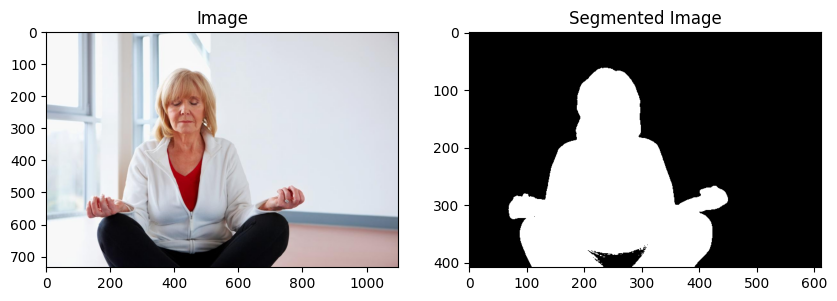

In [27]:
# Get a random image index
random_index = random.randint(0, len(train_image_path_list) - 1)

# Build a to tensor transform function
to_tensor = transforms.ToTensor()

# Transform the base image and segmented image to tensor
image = to_tensor(Image.open(train_image_path_list[random_index]))
segmented_image = to_tensor(Image.open(segmented_image_path_list[random_index]))

plot_images(image, segmented_image)

### 5. Setup Transformation

In [28]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Check out how the transformation is changing the images:

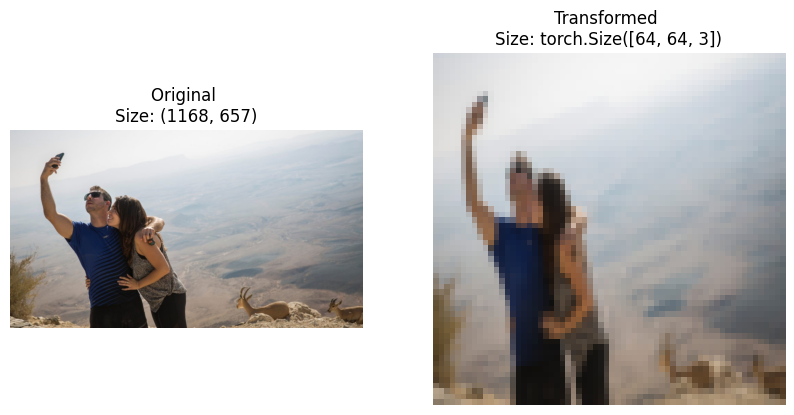

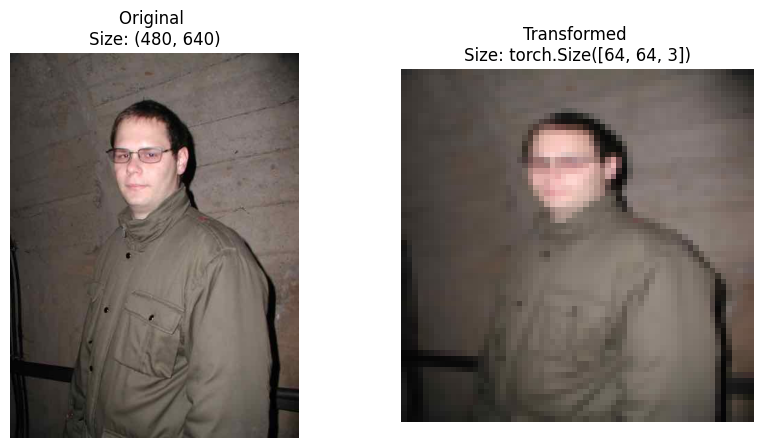

In [30]:
plot_transformed_images(train_image_path_list, data_transform, n=2)

### 6. Create Custom Dataset

In [31]:
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform

  def load_image(self, index: int) -> Image.Image:
      image_path = self.paths[index]
      return Image.open(image_path)

  def __len__(self) -> int:
      "Returns the total number of samples."
      return len(self.paths)

  def __getitem__(self, index: int) -> torch.Tensor:
      "Returns one sample of data, data and label (X, y)."
      img = self.load_image(index)

      # Transform if necessary
      if self.transform:
          return self.transform(img)
      else:
          return img

### 7. Batch the Dataset

### 8. Create The Segmentation Model

### 9. Create Train and Validation Function

### 10. Train Model

### 11. Inference and Predictions